# K-Means Overview

K-Means is an unsupervised machine learning technique that allows one to cluster data points. This enables oneto find patterns in the data that can help one analyze it more effectively. K-means is an iterative algorithm, which means that it will converge to the optimal clustering over time.

To run a k-means clustering:
1. Specify the number of clusters wanted (usually referred to as **k**)
2. Randomly initialize the **centroid** for each cluster. The centroid is the data point that is the center of the cluster.
3. Determine which data points belong to which cluster by finding the closets **centroid** to each data point.
4. Update the centroids based on the geometric mean of all the data points in the cluster.
5. Run 3 and 4 until the **centroids** stop changing. Each run is referred to as an iteration.

## Data Exploration

In [1]:
# pip install seaborn yellowbrick

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

houses = pd.read_csv('data/austinHousingData.csv')
properties = ['zipcode', 
              'homeType', 
              'latestPrice',
              'propertyTaxRate', 
              'numOfBedrooms', 
              'avgSchoolDistance', 
              'avgSchoolRating', 
              'MedianStudentsPerTeacher']
data = houses[properties].copy()
data.head()

,zipcode,homeType,latestPrice,propertyTaxRate,numOfBedrooms,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher
0,78660,Single Family,305000.0,1.98,4,1.266667,2.666667,14
1,78660,Single Family,295000.0,1.98,4,1.400000,2.666667,14
2,78660,Single Family,256125.0,1.98,3,1.200000,3.000000,14
3,78660,Single Family,240000.0,1.98,3,1.400000,2.666667,14
4,78660,Single Family,239900.0,1.98,3,1.133333,4.000000,14


In [3]:
data.describe()

,zipcode,latestPrice,propertyTaxRate,numOfBedrooms,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher
count,15171.000000,1.517100e+04,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000
mean,78735.932964,5.127677e+05,1.994085,3.440380,1.838495,5.779912,14.857228
std,18.893475,4.531853e+05,0.053102,0.849942,1.068376,1.860276,1.741857
min,78617.000000,5.500000e+03,1.980000,0.000000,0.200000,2.333333,10.000000
25%,78727.000000,3.090000e+05,1.980000,3.000000,1.100000,4.000000,14.000000
50%,78739.000000,4.050000e+05,1.980000,3.000000,1.566667,5.778694,15.000000
75%,78749.000000,5.750000e+05,1.980000,4.000000,2.266667,7.000000,16.000000
max,78759.000000,1.350000e+07,2.210000,20.000000,9.000000,9.500000,19.000000


In [4]:
# Map strings to integers, removing text values
# city = {value: key for key, value in enumerate(data['city'].unique())}
zipcode = {value: key for key, value in enumerate(data['zipcode'].unique())}
home_type = {value: key for key, value in enumerate(data['homeType'].unique())}

# data['city'] = data['city'].map(city)
data['zipcode'] = data['zipcode'].map(zipcode)
data['homeType'] = data['homeType'].map(home_type)
data.head()

,zipcode,homeType,latestPrice,propertyTaxRate,numOfBedrooms,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher
0,0,0,305000.0,1.98,4,1.266667,2.666667,14
1,0,0,295000.0,1.98,4,1.400000,2.666667,14
2,0,0,256125.0,1.98,3,1.200000,3.000000,14
3,0,0,240000.0,1.98,3,1.400000,2.666667,14
4,0,0,239900.0,1.98,3,1.133333,4.000000,14


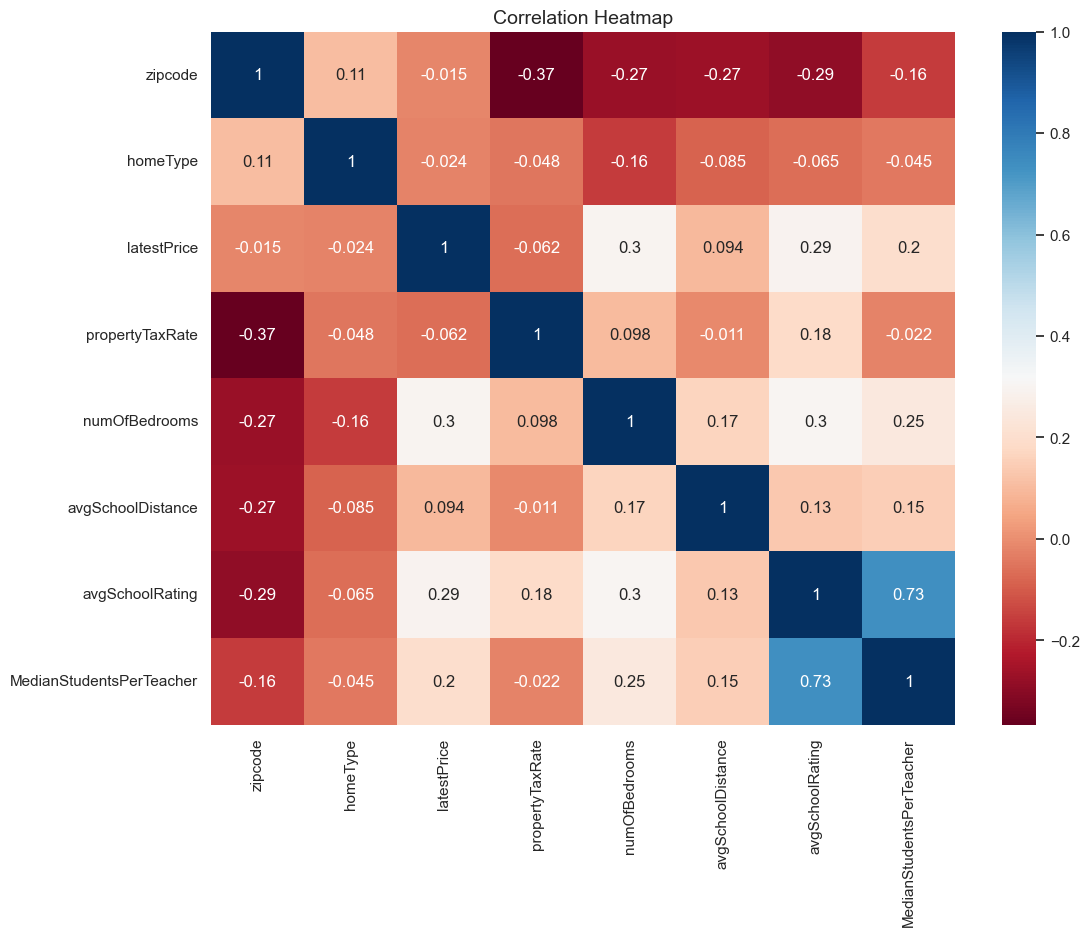

In [5]:
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(), annot=True, cmap='RdBu')
plt.title('Correlation Heatmap', fontsize=14)
plt.yticks(rotation=0)
plt.show()

### Steps
1. Scale the data
2. Initialize random centroids
3. Label each data point
4. Update centroids
5. Repeat steps 3 and 4 until centroids stop changing

In [6]:
# data scaling
# normalizes data to a 1-10 scale

data = ((data - data.min()) / (data.max() - data.min())) * 9 + 1
data.describe() # should show data scaled between 1-10, also preserves variance

,zipcode,homeType,latestPrice,propertyTaxRate,numOfBedrooms,avgSchoolDistance,avgSchoolRating,MedianStudentsPerTeacher
count,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000
mean,5.552552,1.256542,1.338316,1.551143,2.548171,2.675733,5.328262,5.857228
std,2.413387,1.064670,0.302247,2.077906,0.382474,1.092657,2.336160,1.741857
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.489362,1.000000,1.202416,1.000000,2.350000,1.920455,3.093023,5.000000
50%,5.978723,1.000000,1.266442,1.000000,2.350000,2.397727,5.326732,6.000000
75%,7.319149,1.000000,1.379821,1.000000,2.800000,3.113636,6.860465,7.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [7]:
# init random centroids - contains value from each row
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        # iterates over each column and pulls a random value, creats a pandas Series
        centroid = data.apply(lambda x: float(x.sample())) 
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

centroids = random_centroids(data, 5)
centroids

/var/folders/lk/066c21wj7039236zc___rb840000gn/T/ipykernel_91482/2659273345.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  centroid = data.apply(lambda x: float(x.sample()))


,0,1,2,3,4
zipcode,3.297872,4.638298,6.744681,2.531915,1.957447
homeType,1.000000,1.000000,1.000000,1.000000,1.000000
latestPrice,1.186409,1.279781,1.453185,1.289785,1.296387
propertyTaxRate,1.000000,1.000000,1.000000,10.000000,1.000000
numOfBedrooms,1.900000,2.350000,2.800000,1.900000,2.350000
avgSchoolDistance,2.431818,1.511364,2.738636,2.090909,2.840909
avgSchoolRating,4.348837,7.279070,6.441860,4.348837,1.418605
MedianStudentsPerTeacher,7.000000,6.000000,4.000000,5.000000,9.000000


In [8]:
import numpy as np

# use the euclidian distance for a given node (all points for an id) and relate value to that cluster

def get_labels(data, centroids):
    # returns the distances of each feature from a cluster's center
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    # returns the feature with the closest value from a cluster for a given node
    return distances.idxmin(axis=1)

In [9]:
labels = get_labels(data, centroids)
labels.value_counts() # returns each unique value in a given label

2    6441
1    4675
0    3186
3     856
4      13
Name: count, dtype: int64

In [10]:
# update centroids based on what is in the center

# uses the geometric mean (multiplying each point together and taking the nth root based on number of points) 
# to get center of each cluster

# takes natural log in a given row, the mean, and returns E^(value)
# returns geometric mean for each feature
# column: centroids, row: feature
def new_centroids(data, labels, k):
    return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

# plots multivariable data into 2D space
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2D = pca.fit_transform(data)
    centroids_2D = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2D[:,0], y=data_2D[:,1], c=labels)
    plt.scatter(x=centroids_2D[:,0], y=centroids_2D[:,1])
    plt.show()

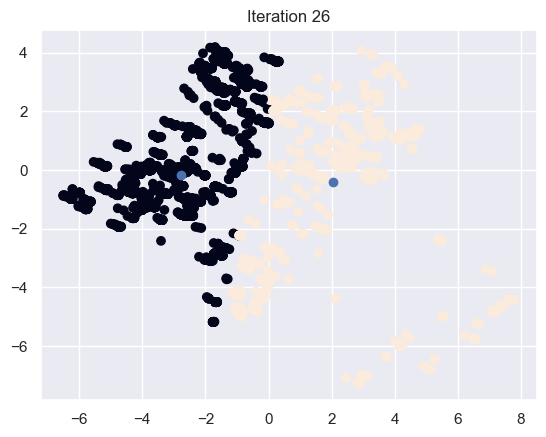

In [12]:
max_itereations = 100
k = 2

centroids = random_centroids(data, k)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_itereations and not centroids.equals(old_centroids):
    old_centroids = centroids

    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, k)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

In [13]:
centroids

,0,1
zipcode,7.289703,3.354833
homeType,1.151701,1.059532
latestPrice,1.285154,1.350186
propertyTaxRate,1.000000,1.362711
numOfBedrooms,2.403035,2.635095
avgSchoolDistance,2.202206,2.805330
avgSchoolRating,3.570187,6.228861
MedianStudentsPerTeacher,4.708713,6.468354


In [14]:
zero_cat = houses[labels==0][['city'] + properties]['zipcode'].unique()
zero_clustered_houses = houses[labels==0].copy()
zero_clustered_houses['cluster'] = 0
    # slightly expensive homes
    # slightly more bedrooms
    # closer to schools
    # (significantly) higher school ratings
    # higher number of students to teachers

one_cat = houses[labels==1][['city'] + properties]['zipcode'].unique()
one_clustered_houses = houses[labels==1].copy()
one_clustered_houses['cluster'] = 1
    # less expensive homes
    # slightly less bedrooms
    # farther from schools
    # (significantly) lower school ratings
    # lower number of students to teachers

In [15]:
clustered_houses = pd.concat([zero_clustered_houses, one_clustered_houses], ignore_index=True)
clustered_houses[['city', 'zipcode', 'cluster']]

,city,zipcode,cluster
0,austin,78753,0
1,austin,78753,0
2,austin,78753,0
3,austin,78719,0
4,austin,78719,0
...,...,...,...
15166,austin,78757,1
15167,austin,78757,1
15168,austin,78757,1
15169,austin,78757,1


In [16]:
import plotly.express as px
from urllib.request import urlopen
import json

with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/tx_texas_zip_codes_geo.min.json') as response:
    zipcodes = json.load(response)


fig = px.choropleth(
    clustered_houses,
    geojson=zipcodes,
    locations='zipcode',
    color='cluster',
    range_color=(1,2),
    scope='usa',
    labels={'cluster': 'cluster_category'}
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

ModuleNotFoundError: No module named 'plotly'